12/27/2017

# Additional Evaluations

## Summary
This notebook contains model evaluation work and "robustness checks" demonstrating 2-hop >> 1-hop performance. Notebook run for Amherst and for MIT, considering additional metrics like precision, recall, etc. Code organization assumes working directory is notebook folder location.


In [1]:
## implemented LINK with solver='lbfgs'
from __future__ import division
from matplotlib.backends.backend_pdf import PdfPages
import os

## relevant libraries
execfile('../functions/python_libraries.py')

## processing datasets
execfile('../functions/create_adjacency_matrix.py') 
execfile('../functions/create_directed_adjacency_matrix.py')
execfile('../functions/compute_homophily.py')
execfile('../functions/compute_monophily.py')


execfile('../functions/parsing.py')
execfile('../functions/mixing.py')

## code for gender prediction 
execfile('../functions/LINK_finalized.py')
execfile('../functions/majority_vote.py')
execfile('../functions/majority_vote_modified.py')


execfile('../functions/benchmark_classifier.py')

## gender preference distribution
execfile('../functions/compute_null_distribution.py')

/Users/jugander/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/jugander/anaconda3/envs/ipykernel_py2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## data file path

In [2]:
## filename where relevant FB100 data is stored
fb100_file = '/Users/kristen/Dropbox/gender_graph_data/FB_processing_pipeline/data/0_original/'
fb100_file = '/Users/jugander/Dropbox/research/GenderGraph/FB_processing_pipeline/data/0_original/'

# Alternative Evaluation Metrics
MIT8 and Amherst41

In [3]:
for f in listdir(fb100_file):
    if f.endswith('.mat'):
        tag = f.replace('.mat', '')
        school = 'Amherst41'  # 'Amherst41' 'MIT8' # we report results for MIT8 and Amherst41
        if (tag==school):
            print tag
            input_file = path_join(fb100_file, f)
            A, metadata = parse_fb100_mat_file(input_file)

            adj_matrix_tmp = A.todense()
            gender_y_tmp = metadata[:,1] #gender
                
            gender_dict = create_dict(range(len(gender_y_tmp)), gender_y_tmp)
                
            (gender_y, adj_matrix_gender) = create_adj_membership(
                                    nx.from_numpy_matrix(adj_matrix_tmp), # graph
                                                           gender_dict,   # dictionary
                                                           0,             # val_to_drop, gender = 0 is missing
                                                           'yes',         # delete_na_cols, ie completely remove NA nodes from graph
                                                           0,             # diagonal
                                                           None,          # directed_type
                                                           'gender')      # gender
            
            gender_y = np.array(map(np.int,gender_y)) ## need np.int for machine precisions reasons

Amherst41


In [4]:
F_fb_label = 1
M_fb_label = 2

In [5]:
print len(gender_y)
print np.sum(gender_y == 1)
print np.sum(gender_y == 2)

2032
1015
1017


In [6]:
#F
in_F_degree = adj_matrix_gender[gender_y==F_fb_label,] * np.matrix((gender_y==F_fb_label)+0).T
total_F_degree = np.sum(adj_matrix_gender[gender_y==F_fb_label,] ,1)
h_F = np.mean(in_F_degree)/np.mean(total_F_degree)

#M
in_M_degree = adj_matrix_gender[gender_y==M_fb_label,] * np.matrix((gender_y==M_fb_label)+0).T
total_M_degree = np.sum(adj_matrix_gender[gender_y==M_fb_label,] ,1)
h_M = np.mean(in_M_degree)/np.mean(total_M_degree)

In [7]:
print h_F - np.mean(gender_y==F_fb_label)
print ''
print h_M - np.mean(gender_y==M_fb_label)

0.04814293556459193

0.01161896606004753


In [8]:
print monophily_index_overdispersion_Williams(adj_matrix_gender, gender_y)

[0.03776731811765727, 0.040642558345226544]


In [9]:
class_values = np.unique(gender_y)
print class_values

[1 2]


## Examine Precision and Recall

In [10]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [11]:
## rerun here for k=1 and then k=2
k=2 # 1 2
adj_amherst_k= np.matrix(adj_matrix_gender)**k
adj_amherst_k[range(adj_amherst_k.shape[0]),range(adj_amherst_k.shape[0])]=0 ## remove self-loops
                    
nonzero_idx1 = np.array((np.sum(adj_amherst_k[gender_y==class_values[0],:],1)!=0).T)[0]
nonzero_idx2 = np.array((np.sum(adj_amherst_k[gender_y==class_values[1],:],1)!=0).T)[0]
mv_g1 = (adj_amherst_k[gender_y==class_values[0],:] * np.matrix((gender_y==class_values[0])+0).T)[nonzero_idx1]/np.sum(adj_amherst_k[gender_y==class_values[0],:],1)[nonzero_idx1]
mv_g2 = (adj_amherst_k[gender_y==class_values[1],:] * np.matrix((gender_y==class_values[1])+0).T)[nonzero_idx2]/np.sum(adj_amherst_k[gender_y==class_values[1],:],1)[nonzero_idx2]

y_score = np.array(np.concatenate((1-mv_g1,mv_g2))).T[0]

y_test = np.concatenate((np.repeat(class_values[0],len(mv_g1)),
                     np.repeat(class_values[1],len(mv_g2))))                    

In [12]:
tn, fp, fn, tp =confusion_matrix(label_binarize(y_test,np.unique(y_test)), 
                 (y_score>(np.mean(gender_y==2)))+0).ravel()
print (tn, fp, fn, tp)

(858, 157, 554, 463)


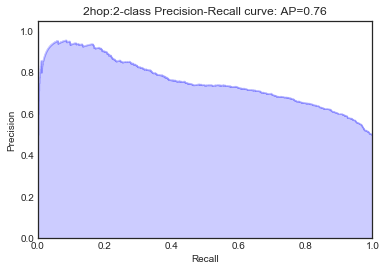

In [13]:
precision2, recall2, thresholds2 = precision_recall_curve(label_binarize(y_test, np.unique(y_test)), 
                                              y_score)
from sklearn.metrics import average_precision_score
average_precision2 = average_precision_score(label_binarize(y_test, np.unique(y_test)), 
                                            y_score)
%matplotlib inline
plt.step(recall2, precision2, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall2, precision2, step='post', alpha=0.2,
                 color='b')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(str(k)+'hop:' + str(k)+ '-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision2))
plt.show()

In [14]:
from sklearn.metrics import roc_curve

In [15]:
fpr, tpr, thresholds = roc_curve(label_binarize(y_test, np.unique(y_test)), 
                                 y_score)#, 
                                 #pos_label=1)
print len(fpr)
print len(thresholds)

848
848


In [16]:
if k == 1:
    %matplotlib inline
    ax = plt.subplot(111)
    ax.axvline(np.mean(gender_y==2),
              color='gray',
              alpha=0.8)
    ax.annotate('accuracy threshold', xy=(np.mean(gender_y==2)+0.17, 0.85), 
                     color='gray', alpha=1, size=12)

    ax.scatter(1-thresholds, fpr,
               color='blue', alpha = 0.2)
    ax.annotate('FPR', xy=(0.1, 0.85), 
                     color='blue', alpha=1, size=12)
    ax.scatter(1-thresholds, tpr,
               color='red', alpha = 0.2)
    ax.annotate('TPR', xy=(0.1, 0.9), 
                     color='red', alpha=1, size=12)
    ax.set_xlabel('Classifier Threshold Cutoff')
    ax.set_ylabel('Performance Metric')
    ax.set_title(school+ ', ' + str(k)+'-MV')

    ax.set_ylim([-0.01, 1.01])
    #ax.set_xlim([-1.01, 1.51])
    ax.set_xlim([-0.51, 1.01])


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    pp = PdfPages('../../figures/' + school +'_tpr_fpr_k'+str(k)+'.pdf')
    pp.savefig()
    pp.close()
    #plt.show()

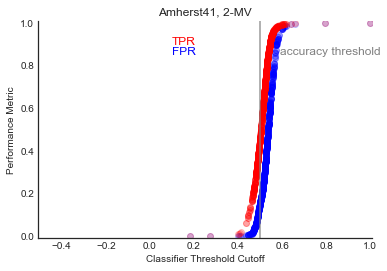

In [17]:
if k==2:
    %matplotlib inline
    ax = plt.subplot(111)
    ax.axvline(np.mean(gender_y==2),
              color='gray',
              alpha=0.8)
    ax.annotate('accuracy threshold', xy=(np.mean(gender_y==2)+0.09, 0.85), 
                     color='gray', alpha=1, size=12)

    ax.scatter(1-thresholds, fpr,
               color='blue', alpha = 0.2)
    ax.annotate('FPR', xy=(0.1, 0.85), 
                     color='blue', alpha=1, size=12)
    ax.scatter(1-thresholds, tpr,
               color='red', alpha = 0.2)
    ax.annotate('TPR', xy=(0.1, 0.9), 
                     color='red', alpha=1, size=12)
    ax.set_xlabel('Classifier Threshold Cutoff')
    ax.set_ylabel('Performance Metric')
    ax.set_title(school+ ', ' + str(k)+'-MV')

    ax.set_ylim([-0.01, 1.01])
    ax.set_xlim([-0.51, 1.01])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    pp = PdfPages('../../figures/' + school +'_tpr_fpr_k'+str(k)+'.pdf')
    pp.savefig()
    pp.close()
    #plt.show()

### Alterntatively report F1-score

In [18]:
print sklearn.metrics.f1_score(label_binarize(y_test, np.unique(y_test)), 
                               np.array(y_score>0.5)+0, #labels=None, pos_label=1, 
                               average='binary', sample_weight=None)

0.5676004872107188


In [19]:
## rerun above part so that precision2, recall2 correspond with k=2
k=1
adj_amherst_k= np.matrix(adj_matrix_gender)**k
adj_amherst_k[range(adj_amherst_k.shape[0]),range(adj_amherst_k.shape[0])]=0 ## remove self-loops
                    
nonzero_idx1 = np.array((np.sum(adj_amherst_k[gender_y==class_values[0],:],1)!=0).T)[0]
nonzero_idx2 = np.array((np.sum(adj_amherst_k[gender_y==class_values[1],:],1)!=0).T)[0]
mv_g1 = (adj_amherst_k[gender_y==class_values[0],:] * np.matrix((gender_y==class_values[0])+0).T)[nonzero_idx1]/np.sum(adj_amherst_k[gender_y==class_values[0],:],1)[nonzero_idx1]
mv_g2 = (adj_amherst_k[gender_y==class_values[1],:] * np.matrix((gender_y==class_values[1])+0).T)[nonzero_idx2]/np.sum(adj_amherst_k[gender_y==class_values[1],:],1)[nonzero_idx2]

y_score = np.array(np.concatenate((1-mv_g1,mv_g2))).T[0]

y_test = np.concatenate((np.repeat(class_values[0],len(mv_g1)),
                     np.repeat(class_values[1],len(mv_g2))))                    

In [20]:
tn, fp, fn, tp =confusion_matrix(label_binarize(y_test,np.unique(y_test)), 
                 (y_score>(np.mean(gender_y==2)))+0).ravel()
print tn, fp, fn, tp 

727 288 499 518


Text(0.5,1,u'1hop: 2-class Precision-Recall curve: AP=0.66')

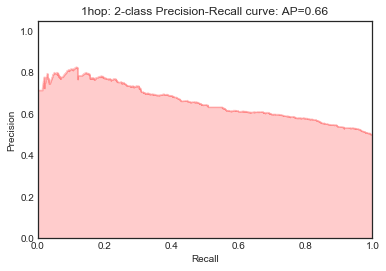

In [21]:
precision, recall, thresholds = precision_recall_curve(label_binarize(y_test, np.unique(y_test)), 
                                              y_score)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(label_binarize(y_test, np.unique(y_test)), 
                                            y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='r')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('1hop: 2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

### Alterntatively report F1-score

In [22]:
print sklearn.metrics.f1_score(label_binarize(y_test, np.unique(y_test)), 
                               np.array(y_score>0.5)+0, #labels=None, pos_label=1, 
                               average='binary', sample_weight=None)

0.5682940208447614


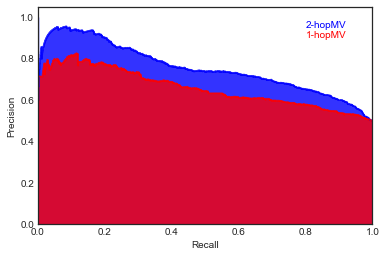

In [23]:
plt.step(recall2, precision2, color='b', alpha=0.8,
         where='post')
plt.fill_between(recall2, precision2, step='post', alpha=0.8,
                 color='b')
plt.text(0.8,0.95,'2-hopMV',color = 'b')


plt.step(recall, precision, color='r', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.8,
                 color='red')

plt.text(0.8,0.9,'1-hopMV',color = 'red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
#plt.show()
pp = PdfPages('../../figures/' + school +'_precision_recall.pdf')
pp.savefig()
pp.close()

In [24]:
px1 = precision[0:len(precision)-1]
rx1 = recall[0:len(recall)-1]

px2 = precision2[0:len(precision2)-1]
rx2 = recall2[0:len(recall2)-1]


In [25]:
idx2 = np.array(range(0,len(rx2), 100))
idx = np.array(range(0,len(rx1), 100))

In [26]:
np.mean(gender_y==2)

0.500492125984252

In [27]:
if school == 'Amherst41':
    idx_accuracy = np.array(thresholds==0.5)#np.mean(gender_y==2))
    print np.sum(idx_accuracy)
    idx_accuracy2 = np.array(thresholds2==0.5)#np.mean(gender_y==2))
    print np.sum(idx_accuracy2)
if school == 'MIT8':
    idx_accuracy = np.array(thresholds==0.6)#np.mean(gender_y==2))
    print np.sum(idx_accuracy)
    idx_accuracy2 = np.array(thresholds2==0.6)#np.mean(gender_y==2))
    print np.sum(idx_accuracy2)


1
1


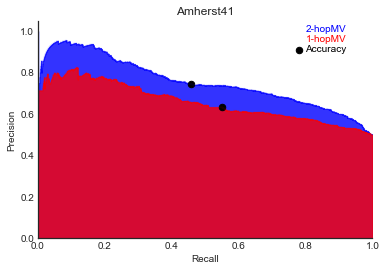

In [28]:

%matplotlib inline
ax = plt.subplot(111)
ax.step(recall2, precision2, color='b', alpha=0.1,
         where='post')
ax.fill_between(recall2, precision2, step='post', alpha=0.8,
                 color='b')
ax.text(0.8,1,'2-hopMV',color = 'b')
ax.text(0.8,0.9,'Accuracy',color = 'black')
ax.scatter(0.78,0.91, color = 'black',s=42, alpha = 1)



ax.step(recall, precision, color='r', alpha=0.1,
         where='post')
ax.fill_between(recall, precision, step='post', alpha=0.8,
                 color='red')

ax.scatter(rx2[idx_accuracy2], px2[idx_accuracy2], color = 'black',s=42, alpha = 1)
ax.scatter(rx1[idx_accuracy], px1[idx_accuracy], color = 'black', s=42, alpha = 1)


ax.text(0.8,0.95,'1-hopMV',color = 'red')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_ylim([0.0, 1.05])
ax.set_xlim([0.0, 1.0])
ax.set_title(school)

#plt.show()
pp = PdfPages('../../figures/' + school +'_precision_recall.pdf')
pp.savefig()
pp.close()